In [1]:
# Master File for Data Studies on L1 Muon RoI Trigger

# Description

# Action Plan
# Change ggH to m50ct1m
# 

# Transition to Analysis
# Look at cscT for signal/background

# Notes
# Check barrel acceptance (theoretical rationale, data supports acceptance trend)
# Find out reason behind gen/reco selection differences (z-cut dependent)
# nCsc: 1 cluster from each plane combined to find a pos/dir measurement in a single chamber ('hit')

In [2]:
work_location = input("Where are you working? ")
if work_location == 'remote':
    pwd = '/nfshome/nasurijr/delayed_jet_analyzer/'
elif work_location == 'desktop':
    pwd = '/home/cms/delayed_jet_analyzer/'

Where are you working? remote


In [3]:
import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

import sys
sys.path.append(pwd+'lib')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

donotdelete = []

Welcome to JupyROOT 6.16/00


In [4]:
varList = [
    'nCsc',
    'cscEta',
    'cscX',
    'cscY',
    'cscZ',
    'cscPhi',
    'cscT',
    'gLLP_decay_vertex_z',
    'gLLP_decay_vertex_y',
    'gLLP_decay_vertex_x',
    'gLLP_eta',
    'gLLP_phi',
    'jetPt'
]

In [5]:
fpath = {}
tree = {}
process = {}

data_path = pwd+'data/'

fpath['qcd'] = data_path +'jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root'
# fpath['zeroBias'] = data_path +'jet_timing_studies_ZeroBias_Run2018A_roctest2.root'
fpath['zeroBias'] = data_path +'jet_timing_studies_ZeroBias_Run2018B_11_dec.root'

# mH = 125 GeV, mX = 50 GeV, ctau = 1 m ['ggH']
fpath['ggH'] = data_path + 'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root'

# mH = 125 GeV, mX = 50 GeV, ctau = 10 m
fpath['m50ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'
# fpath['ggH'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'


# mH = 2000 GeV, mX = 975 GeV, ctau = 1 m
fpath['m975ct1000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root'
# fpath['ggH'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root'

# mH = 2000 GeV, mX = 975 GeV, ctau = 10 m
fpath['m975ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl10000_ev100000.root'
# fpath['ggH'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl10000_ev100000.root'

for k,v in fpath.items():
    print(str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
    print(k, v)
    tree[k] = rtnp.root2array(v, branches = varList)
    a = tree[k]["cscZ"]
    print(a[:-1][0])

2019-07-22 09:45:57.209693-07:00
qcd /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root
[ 616.924   -616.99866]
2019-07-22 09:45:57.690331-07:00
zeroBias /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ZeroBias_Run2018B_11_dec.root
[ 617.07245 -616.8515  -587.7236  -587.65125]
2019-07-22 09:46:10.214820-07:00
ggH /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root
[ 587.72986 1037.2808  -616.96265 -616.978   -816.0506  -947.9157 ]
2019-07-22 09:46:10.745836-07:00
m50ct10000mm /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root
[  617.05396   685.0102   -587.6214   -587.65497 -1037.2885 ]
2019-07-22 09:46:11.170926-07:00
m975ct1000mm /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root
[ 617.11694  

In [6]:
T = tree['ggH']
T_bkg = tree['qcd']
T_minBias = tree['zeroBias']
T_low_ctau10 = tree['m50ct10000mm']
T_high_ctau1 = tree['m975ct1000mm']
T_high_ctau10 = tree['m975ct10000mm']

In [7]:
#get first jet pt per event
# print(T['jetPt'])
first_jet_pt = [x[0] if len(x) else -1 for x in T['jetPt']]

x = np.arange(-5, 5, 1)
y = np.arange(-5, 5, 1)
xx, yy = np.meshgrid(x, y, sparse=True)

#get max jet pt per event
max_jet_pt = [np.max(np.abs(x)) if len(x) else -1 for x in T['gLLP_decay_vertex_z']]

#store jet-pt array per event in a list
first_jet_pt_arr = []
for x in T['jetPt']:
    if len(x) == 0:
        break
    #print x
    first_jet_pt_arr.append(x[0])

In [8]:
# k-means clustering algorithm
# For more information, check out https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

MAX_ITERATIONS = 100
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    return np.array_equal(oldCentroids,centroids) and iterations > 0


# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids, i):
    #print 1
    #for i in dataSet:
    dist = cdist( dataSet, centroids, metric='euclidean' )
    
    #print dist
    if i < 1:
        dist[dist>1.0] = 999
    elif i < 2:
        dist[dist>0.8] = 999
    else:
        dist[dist>0.4] = 999
        
    #print dist
    #print np.argmin(dist, axis=1)
    return np.argmin(dist, axis=1)
    #print dataSet
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.average(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getRandomCentroids():
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    even_list = np.linspace(-4.0, 4.0, num=5)
    centers  = np.empty((0,2))
    for i in even_list:
        for j in even_list:
            #print i,j
            new_arr = np.array([i,j])
            centers = np.append(centers,[new_arr],axis=0)
    #print centers
    return centers
    #return np.mgrid[-4:4.1:2, -4:4.1:2].reshape(2,-1).T
    #return np.random.rand(k,numFeatures)

# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmeans(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

In [9]:
print(len(T_minBias['nCsc']))
print(len(T_bkg['nCsc']))
print(T['cscT'])

1794460
59068
[array([ 73.82982  ,  -8.959195 ,  -0.7134635, 105.828636 , -12.121994 ,
        73.59416  ], dtype=float32)
 array([ 54.79526, -32.65719], dtype=float32)
 array([-51.59032  , -48.504436 , -44.912968 , -41.41847  , -22.381765 ,
       -47.832798 , -46.42273  , -44.868748 , -44.229225 ,  73.36788  ,
        40.863136 ,  -2.424031 ,  73.68292  , -48.875927 ,  82.80764  ,
        79.05054  ,  73.11037  ,  -1.8328142], dtype=float32)
 ...
 array([ 50.443043  ,   0.31258994,  66.32775   , -25.454853  ,
       -47.964302  , -39.60516   ,   9.287068  ], dtype=float32)
 array([-0.99539965], dtype=float32)
 array([25.487743 , -3.0890398, 23.615753 ,  3.782443 , 28.593092 ,
        2.955476 , 42.046803 , 25.251816 ,  3.5885086, 60.67004  ],
      dtype=float32)]


In [28]:
# Variable Definitions

nCsc = {}
nCsc_phi_gran = {}
csc_z = {}
csc_x = {}
csc_y = {}
csc_t = {}
csc_eta = {}
csc_phi = {}
gLLP_eta = {}
gLLP_r = {}
gLLP_decay = {}

# T_low_ctau10 = tree['m50ct10000mm']
# T_high_ctau1 = tree['m975ct1000mm']
# T_high_ctau10 = tree['m975ct10000mm']

data_trees = {'ggH': T, 'qcd': T_bkg, 'zeroBias':T_minBias, 'm50ct10m': T_low_ctau10, 'm975ct1m': T_high_ctau1, 'm975ct10m': T_high_ctau10}

In [12]:
# # Hit Selection based on Phi Granularity



# # for files in data_trees.keys():
# #     nCsc_station[files] = {}
# #     nCsc_station[files]['ME_11'] = []
# #     nCsc_station[files]['ME_12'] = []
# #     nCsc_station[files]['ME_13'] = []
    
# #     for pos_bool in range(len(csc_z[files])):
# #         csc_r = np.sqrt(csc_x[files][pos_bool]**2+csc_y[files][pos_bool]**2)
# #         z_pos_bool = csc_z[files][pos_bool]
        
# #         counter_me11 = 0
# #         counter_me12 = 0
# #         counter_me13 = 0
        
# #         for z_ind in range(len(z_pos_bool)):
# #             z_bool = np.absolute(z_pos_bool[z_ind])
# #             if z_bool > 568 and z_bool < 632:
# #                 counter_me11 += 1
# #             if z_bool > 663 and z_bool < 724:
# #                 if csc_r[z_ind] < 465 and csc_r[z_ind] > 275:
# #                     counter_me12 += 1
# #                 if csc_r[z_ind] < 695.5 and csc_r[z_ind] > 505.5:
# #                     counter_me13 += 1
# #         nCsc_station[files]['ME_11'].append(counter_me11)
# #         nCsc_station[files]['ME_12'].append(counter_me12)
# #         nCsc_station[files]['ME_13'].append(counter_me13)

pg_ncsc = {}
pg_ncsc_noME11 = {}
pg_ncsc_noME112 = {}
pg_ncsc_noME1123 = {}

for species, arbor in data_trees.items():
#     phi_slice_counter = 0
    pg_ncsc[species] = []
    pg_ncsc_noME11[species] = []
    pg_ncsc_noME112[species] = []
    pg_ncsc_noME1123[species] = []
    
    for event in range(len(arbor['cscZ'])):
        cscR = np.sqrt(arbor['cscX'][event]**2+arbor['cscY'][event]**2)
        cscZ = arbor['cscZ'][event]
        cscPhi = arbor['cscPhi'][event] * (180/np.pi)
        
        # Make a dictionary with pg_meXX = {sectors:np.zeros(36), counter:0}
        # Station specific sector arrays are then updated exactly as before
        # np.count_nonzero is then appended to counters
#         pg_counter_me11 = 0
#         pg_counter_me12 = 0
#         pg_counter_me13 = 0
#         pg_counter_me21 = 0
#         pg_counter_me22 = 0
#         pg_counter_me31 = 0
#         pg_counter_me32 = 0
#         pg_counter_me41 = 0
#         pg_counter_me42 = 0
        pg_me11 = {'sectors':np.zeros(36), 'counter':0}
        pg_me12 = {'sectors':np.zeros(36), 'counter':0}
        pg_me13 = {'sectors':np.zeros(36), 'counter':0}
        pg_me21 = {'sectors':np.zeros(36), 'counter':0}
        pg_me22 = {'sectors':np.zeros(36), 'counter':0}
        pg_me31 = {'sectors':np.zeros(36), 'counter':0}
        pg_me32 = {'sectors':np.zeros(36), 'counter':0}
        pg_me41 = {'sectors':np.zeros(36), 'counter':0}
        pg_me42 = {'sectors':np.zeros(36), 'counter':0}
        
        
        for zIndex in range(len(cscZ)):
            hit_z = np.absolute(cscZ[zIndex])
            hit_phi = cscPhi[zIndex]
            hit_r = cscR[zIndex]
            
            # ME 1/1
            if hit_z > 568 and hit_z < 632:
                index = int((hit_phi+180)/10.0)
                if index == pg_me11['sectors'].size:
                    pg_me11['sectors'][pg_me11['sectors'].size - 1] += 1
                else:
                    pg_me11['sectors'][index] += 1
#             # ME 1/2 and ME 1/3
            if hit_z > 663 and hit_z < 724:
                if hit_r < 465 and hit_r > 275:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me12['sectors'].size:
                        pg_me12['sectors'][pg_me12['sectors'].size - 1] += 1
                    else:
                        pg_me12['sectors'][index] += 1
                if hit_r < 695.5 and hit_r > 505.5:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me13['sectors'].size:
                        pg_me13['sectors'][pg_me13['sectors'].size - 1] += 1
                    else:
                        pg_me13['sectors'][index] += 1
            # ME 2/1 and ME 2/2
            if hit_z > 791 and hit_z < 849.5:
                if hit_r < 345 and hit_r > 138.5:
                    index = int((hit_phi+180)/20.0)
                    if index == pg_me21['sectors'].size:
                        pg_me21['sectors'][pg_me21['sectors'].size - 1] += 1
                    else:
                        pg_me21['sectors'][index] += 1
                if hit_r < 695.5 and hit_r > 357.5:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me22['sectors'].size:
                        pg_me22['sectors'][pg_me22['sectors'].size - 1] += 1
                    else:
                        pg_me22['sectors'][index] += 1                       
            # ME 3/1 and ME 3/2
            if hit_z > 911.5 and hit_z < 970:
                if hit_r < 345 and hit_r > 160.5:
                    index = int((hit_phi+180)/20.0)
                    if index == pg_me31['sectors'].size:
                        pg_me31['sectors'][pg_me31['sectors'].size - 1] += 1
                    else:
                        pg_me31['sectors'][index] += 1
                if hit_r < 695.5 and hit_r > 357.5:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me32['sectors'].size:
                        pg_me32['sectors'][pg_me32['sectors'].size - 1] += 1
                    else:
                        pg_me32['sectors'][index] += 1    
            # ME 4/1 and ME 4/2
            if hit_z > 1002 and hit_z < 1060.5:
                if hit_r < 345 and hit_r > 177.5:
                    index = int((hit_phi+180)/20.0)
                    if index == pg_me41['sectors'].size:
                        pg_me41['sectors'][pg_me41['sectors'].size - 1] += 1
                    else:
                        pg_me41['sectors'][index] += 1
                if hit_r < 695.5 and hit_r > 357.5:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me42['sectors'].size:
                        pg_me42['sectors'][pg_me42['sectors'].size - 1] += 1
                    else:
                        pg_me42['sectors'][index] += 1
                    
        pg_me11['counter'] += np.count_nonzero(pg_me11['sectors'])
        pg_me12['counter'] += np.count_nonzero(pg_me12['sectors'])
        pg_me13['counter'] += np.count_nonzero(pg_me13['sectors'])
        pg_me21['counter'] += np.count_nonzero(pg_me21['sectors'])
        pg_me22['counter'] += np.count_nonzero(pg_me22['sectors'])
        pg_me31['counter'] += np.count_nonzero(pg_me31['sectors'])
        pg_me32['counter'] += np.count_nonzero(pg_me32['sectors'])
        pg_me41['counter'] += np.count_nonzero(pg_me41['sectors'])
        pg_me42['counter'] += np.count_nonzero(pg_me42['sectors'])
        

        cscSum_inclusive = pg_me11['counter'] + pg_me12['counter'] + pg_me13['counter'] + pg_me21['counter'] + pg_me22['counter'] + pg_me31['counter'] + pg_me32['counter'] + pg_me41['counter'] + pg_me42['counter']
        cscSum_noME11 = pg_me12['counter'] + pg_me13['counter'] + pg_me21['counter'] + pg_me22['counter'] + pg_me31['counter'] + pg_me32['counter'] + pg_me41['counter'] + pg_me42['counter']
        cscSum_noME112 = pg_me13['counter'] + pg_me21['counter'] + pg_me22['counter'] + pg_me31['counter'] + pg_me32['counter'] + pg_me41['counter'] + pg_me42['counter']
        cscSum_noME1123 = pg_me21['counter'] + pg_me22['counter'] + pg_me31['counter'] + pg_me32['counter'] + pg_me41['counter'] + pg_me42['counter']
        
        pg_ncsc[species].append(cscSum_inclusive)
        pg_ncsc_noME11[species].append(cscSum_noME11)
        pg_ncsc_noME112[species].append(cscSum_noME112)
        pg_ncsc_noME1123[species].append(cscSum_noME1123)
    '
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

ggH: 2019-07-22 09:59:50.800891-07:00
qcd: 2019-07-22 10:00:09.879395-07:00
zeroBias: 2019-07-22 10:00:24.912115-07:00
m50ct10m: 2019-07-22 10:05:16.287080-07:00
m975ct1m: 2019-07-22 10:05:33.180267-07:00
m975ct10m: 2019-07-22 10:05:37.729676-07:00


In [29]:
# Signal Selection
# gLLP_r_0 = np.sqrt((T['gLLP_decay_vertex_x'][:,0])**2+(T['gLLP_decay_vertex_y'][:,0])**2)
# gLLP_r_low_ctau10 = np.sqrt((T_low_ctau10['gLLP_decay_vertex_x'][:,0])**2+(T_low_ctau10['gLLP_decay_vertex_y'][:,0])**2)
# gLLP_r_high_ctau1 = np.sqrt((T_high_ctau1['gLLP_decay_vertex_x'][:,0])**2+(T_high_ctau1['gLLP_decay_vertex_y'][:,0])**2)
# gLLP_r_high_ctau10 = np.sqrt((T_high_ctau10['gLLP_decay_vertex_x'][:,0])**2+(T_high_ctau10['gLLP_decay_vertex_y'][:,0])**2)

# gLLP_decay_0 = np.sqrt((T['gLLP_decay_vertex_x'][:,0])**2+(T['gLLP_decay_vertex_y'][:,0])**2 + (T['gLLP_decay_vertex_z'][:,0])**2)
# gLLP_decay_low_ctau10 = np.sqrt((T_low_ctau10['gLLP_decay_vertex_x'][:,0])**2+(T_low_ctau10['gLLP_decay_vertex_y'][:,0])**2 + (T_low_ctau10['gLLP_decay_vertex_z'][:,0])**2)
# gLLP_decay_high_ctau1 = np.sqrt((T_high_ctau1['gLLP_decay_vertex_x'][:,0])**2+(T_high_ctau1['gLLP_decay_vertex_y'][:,0])**2 + (T_high_ctau1['gLLP_decay_vertex_z'][:,0])**2)
# gLLP_decay_high_ctau10 = np.sqrt((T_high_ctau10['gLLP_decay_vertex_x'][:,0])**2+(T_high_ctau10['gLLP_decay_vertex_y'][:,0])**2 + (T_high_ctau10['gLLP_decay_vertex_z'][:,0])**2)



if 'metbb' in fpath['ggH']:
#     sel_displaced = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) > 568 , np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 1100)
#     sel_displaced = np.logical_and(sel_displaced, np.absolute(T['gLLP_eta'][:,0])<2.4)
#     sel_displaced = np.logical_and(sel_displaced, np.absolute(T['gLLP_eta'][:,0])>0.9)
#     sel_displaced = np.logical_and(sel_displaced, np.absolute(gLLP_r_0)<695.5)
    
#     sel_dis_barrel = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) > -661 , np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 661)
#     sel_dis_barrel = np.logical_and(sel_dis_barrel, np.absolute(gLLP_r_0)<738)
#     sel_dis_barrel = np.logical_and(sel_dis_barrel, np.absolute(gLLP_r_0)>380)
    
#     sel_rpc = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) > 568 , np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 1100)
#     sel_rpc = np.logical_and(sel_rpc, np.absolute(T['gLLP_eta'][:,0])<1.6)
#     sel_rpc = np.logical_and(sel_rpc, np.absolute(gLLP_r_0)<738)
    
#     sel_dis_signal = np.logical_or(sel_displaced, sel_dis_barrel)
    
#     gLLPz_sel = T['gLLP_decay_vertex_z'][:,0][sel_displaced]
#     nCsc_dis_sel = T['nCsc'][sel_displaced]
#     print('Total Number of Events: ' + str(len(T['nCsc'])))
#     print('Endcap Selection: ' + str(len(nCsc_dis_sel)))
#     print('Barrel Selection: ' + str(len(T['nCsc'][sel_dis_barrel])))
#     print('Signal Selection: ' + str(len(T['nCsc'][sel_dis_signal])))
    
#     sel_bkg = [True if np.any(x > 50) else False for x in T_bkg['jetPt']]
#     sel_minBias = [True if np.any(x > 50) else False for x in T_minBias['jetPt']]
    
    for species, arbor in data_trees.items():
        gLLP_r[species] = np.sqrt((arbor['gLLP_decay_vertex_x'][:,0])**2+(arbor['gLLP_decay_vertex_y'][:,0])**2)
        gLLP_decay[species] = np.sqrt((arbor['gLLP_decay_vertex_x'][:,0])**2+(arbor['gLLP_decay_vertex_y'][:,0])**2 + (arbor['gLLP_decay_vertex_z'][:,0])**2)
        
        sel_displaced = np.logical_and( np.absolute(arbor['gLLP_decay_vertex_z'][:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'][:,0]) < 1100)
        sel_displaced = np.logical_and(sel_displaced, np.absolute(arbor['gLLP_eta'][:,0])<2.4)
        sel_displaced = np.logical_and(sel_displaced, np.absolute(arbor['gLLP_eta'][:,0])>0.9)
        sel_displaced = np.logical_and(sel_displaced, np.absolute(gLLP_r[species])<695.5)

        sel_dis_barrel = np.logical_and( np.absolute(arbor['gLLP_decay_vertex_z'][:,0]) > -661 , np.absolute(arbor['gLLP_decay_vertex_z'][:,0]) < 661)
        sel_dis_barrel = np.logical_and(sel_dis_barrel, np.absolute(gLLP_r[species])<738)
        sel_dis_barrel = np.logical_and(sel_dis_barrel, np.absolute(gLLP_r[species])>380)

        sel_rpc = np.logical_and( np.absolute(arbor['gLLP_decay_vertex_z'][:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'][:,0]) < 1100)
        sel_rpc = np.logical_and(sel_rpc, np.absolute(arbor['gLLP_eta'][:,0])<1.6)
        sel_rpc = np.logical_and(sel_rpc, np.absolute(gLLP_r[species])<738)

        sel_dis_signal = np.logical_or(sel_displaced, sel_dis_barrel)

#         gLLPz_sel = arbor['gLLP_decay_vertex_z'][:,0][sel_displaced]
#         nCsc_dis_sel = arbor['nCsc'][sel_displaced]
#         print('Total Number of Events: ' + str(len(T['nCsc'])))
#         print('Endcap Selection: ' + str(len(nCsc_dis_sel)))
#         print('Barrel Selection: ' + str(len(T['nCsc'][sel_dis_barrel])))
#         print('Signal Selection: ' + str(len(T['nCsc'][sel_dis_signal])))

        sel_bkg = [True if np.any(x > 50) else False for x in T_bkg['jetPt']]
        sel_minBias = [True if np.any(x > 50) else False for x in T_minBias['jetPt']]
        
        if species in ('ggH', 'm50ct10m', 'm975ct1m', 'm975ct10m'):
            nCsc[species] = arbor['nCsc'][sel_displaced]
#             pg_ncsc_sel[species] = np.array(pg_ncsc[species])[sel_displaced]            
            csc_z[species] = arbor['cscZ'][sel_displaced]
            csc_x[species] = arbor['cscX'][sel_displaced]
            csc_y[species] = arbor['cscY'][sel_displaced]
            csc_t[species] = arbor['cscT'][sel_displaced]
            csc_eta[species] = arbor['cscEta'][sel_displaced]
            csc_phi[species] = arbor['cscPhi'][sel_displaced]
            gLLP_eta[species] = arbor['gLLP_eta'][:,0][sel_displaced]

        if species == 'qcd':
            nCsc[species] = arbor['nCsc'][sel_bkg]
#             pg_ncsc_sel[species] = np.array(pg_ncsc[species])[sel_bkg]
            csc_z[species] = arbor['cscZ'][sel_bkg]
            csc_x[species] = arbor['cscX'][sel_bkg]
            csc_y[species] = arbor['cscY'][sel_bkg]
            csc_t[species] = arbor['cscT'][sel_bkg]
            csc_eta[species] = arbor['cscEta'][sel_bkg]
            csc_phi[species] = arbor['cscPhi'][sel_bkg]
            
        if species == 'zeroBias':
            nCsc[species] = arbor['nCsc'][sel_minBias]
#             pg_ncsc_sel[species] = np.array(pg_ncsc[species])[sel_minBias]            
            csc_z[species] = arbor['cscZ'][sel_minBias]
            csc_x[species] = arbor['cscX'][sel_minBias]
            csc_y[species] = arbor['cscY'][sel_minBias]
            csc_t[species] = arbor['cscT'][sel_minBias]            
            csc_eta[species] = arbor['cscEta'][sel_minBias]
            csc_phi[species] = arbor['cscPhi'][sel_minBias]
        
        print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

In [20]:
# print(np.array(pg_ncsc['ggH']))
# print(T['nCsc'][2])
# print((T['cscPhi']*(180/np.pi))[2])
# print((T['cscZ'])[2])
# pg_counter_me11 = 0
# for zIndex in range(len(T['cscZ'][2])):
#     hit_z = np.absolute(T['cscZ'][2][zIndex])
#     hit_phi = T['cscPhi'][2][zIndex]
# #     hit_r = csc_r[zIndex]
            
#     # ME 1/1
#     if hit_z > 568 and hit_z < 632:
#         index = int((hit_phi+180)/10.0)
#         pg_sector = np.zeros(36)
#         if index == pg_sector.size:
#             pg_sector[pg_sector.size - 1] += 1
#         else:
#             pg_sector[index] += 1
#         print(index)
#         pg_counter_me11 += np.count_nonzero(pg_sector)
# print(pg_counter_me11)

In [21]:
# Selection Variables

nCsc_station = {}
nCsc_removal = {}
for files in data_trees.keys():
    nCsc_station[files] = {}
    nCsc_station[files]['ME_11'] = []
    nCsc_station[files]['ME_12'] = []
    nCsc_station[files]['ME_13'] = []
    
    for pos_bool in range(len(csc_z[files])):
        csc_r = np.sqrt(csc_x[files][pos_bool]**2+csc_y[files][pos_bool]**2)
        z_pos_bool = csc_z[files][pos_bool]
        
        counter_me11 = 0
        counter_me12 = 0
        counter_me13 = 0
        
        for z_ind in range(len(z_pos_bool)):
            z_bool = np.absolute(z_pos_bool[z_ind])
            if z_bool > 568 and z_bool < 632:
                counter_me11 += 1
            if z_bool > 663 and z_bool < 724:
                if csc_r[z_ind] < 465 and csc_r[z_ind] > 275:
                    counter_me12 += 1
                if csc_r[z_ind] < 695.5 and csc_r[z_ind] > 505.5:
                    counter_me13 += 1
        nCsc_station[files]['ME_11'].append(counter_me11)
        nCsc_station[files]['ME_12'].append(counter_me12)
        nCsc_station[files]['ME_13'].append(counter_me13)
    
    # nCsc dictionaries containing hits removed labelled by removed stations
    nCsc_removal[files] = {}
    nCsc_removal[files]['ME_11'] = np.array(nCsc[files]) - np.array(nCsc_station[files]['ME_11'])
    nCsc_removal[files]['ME_112'] = np.array(nCsc[files]) - (np.array(nCsc_station[files]['ME_11']) + np.array(nCsc_station[files]['ME_12']))
    nCsc_removal[files]['ME_1123'] = np.array(nCsc[files]) - (np.array(nCsc_station[files]['ME_11']) + np.array(nCsc_station[files]['ME_12']) + np.array(nCsc_station[files]['ME_13']))
    
    print(files + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

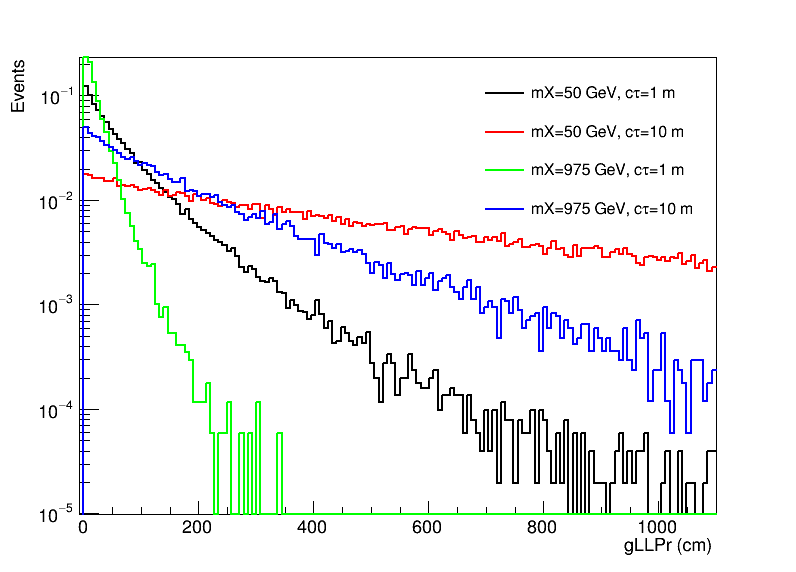

In [22]:
cR = rt.TCanvas('cR','cR', 800, 600)
h={}
h['gLLPr'] = create_TH1D(gLLP_r['ggH'], axis_title=['nCsc_dis', 'Events'], name='gLLPr', binning=[150,0,1100])
h['gLLPr_low_ctau10'] = create_TH1D(gLLP_r['m50ct10m'], axis_title=['nCsc_dis', 'Events'], name='gLLPr_low_ctau10', binning=[150,0,1100])
h['gLLPr_high_ctau1'] = create_TH1D(gLLP_r['m975ct1m'], axis_title=['nCsc_dis', 'Events'], name='gLLPr_high_ctau1', binning=[150,0,1100])
h['gLLPr_high_ctau10'] = create_TH1D(gLLP_r['m975ct10m'], axis_title=['nCsc_dis', 'Events'], name='gLLPr_high_ctau10', binning=[150,0,1100])


cR.SetLogy()

h['gLLPr'].Scale(1.0/h['gLLPr'].Integral())
h['gLLPr_low_ctau10'].Scale(1.0/h['gLLPr_low_ctau10'].Integral())
h['gLLPr_high_ctau1'].Scale(1.0/h['gLLPr_high_ctau1'].Integral())
h['gLLPr_high_ctau10'].Scale(1.0/h['gLLPr_high_ctau10'].Integral())


h['gLLPr'].GetXaxis().SetRangeUser(-1,1100)

h['gLLPr'].SetLineWidth(2)
h['gLLPr'].SetLineColor(1)

h['gLLPr_low_ctau10'].SetLineWidth(2)
h['gLLPr_low_ctau10'].SetLineColor(2)

h['gLLPr_high_ctau1'].SetLineWidth(2)
h['gLLPr_high_ctau1'].SetLineColor(3)

h['gLLPr_high_ctau10'].SetLineWidth(2)
h['gLLPr_high_ctau10'].SetLineColor(4)

h['gLLPr'].SetStats(0)
h['gLLPr'].SetTitle("")
h['gLLPr'].SetXTitle("gLLPr (cm)")

h['gLLPr'].Draw('histo')
h['gLLPr_low_ctau10'].Draw('histo+same')
h['gLLPr_high_ctau1'].Draw('histo+same')
h['gLLPr_high_ctau10'].Draw('histo+same')


legend = rt.TLegend(0.60,0.60,0.87,0.87);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['gLLPr'], "mX=50 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['gLLPr_low_ctau10'], "mX=50 GeV, c#tau=10 m" , "L");
legend.AddEntry( h['gLLPr_high_ctau1'], "mX=975 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['gLLPr_high_ctau10'], "mX=975 GeV, c#tau=10 m" , "L");
legend.Draw();

cR.Draw()

In [23]:
# Selection of Events for Event Display Purposes (Test area)

# T_low_ctau10
# T_high_ctau1
# T_high_ctau10 

# index_ev = np.where(np.logical_and(np.array(gLLP_r_high_ctau1)>300, np.array(T_high_ctau1['gLLP_decay_vertex_z'][:,0])<661))
# print(T_high_ctau1['eventNum'][index_ev])
# print(T_high_ctau1['lumiNum'][index_ev])
# print(T_high_ctau1['gLLP_decay_vertex_z'][:,0][index_ev])
# print(T_high_ctau1['gLLP_eta'][:,0][index_ev])

# print(T_high_ctau1['nCsc'][index_ev])
# # print(T_high_ctau1['calojetEta'][index_ev])

# print(gLLP_r_high_ctau1[index_ev])

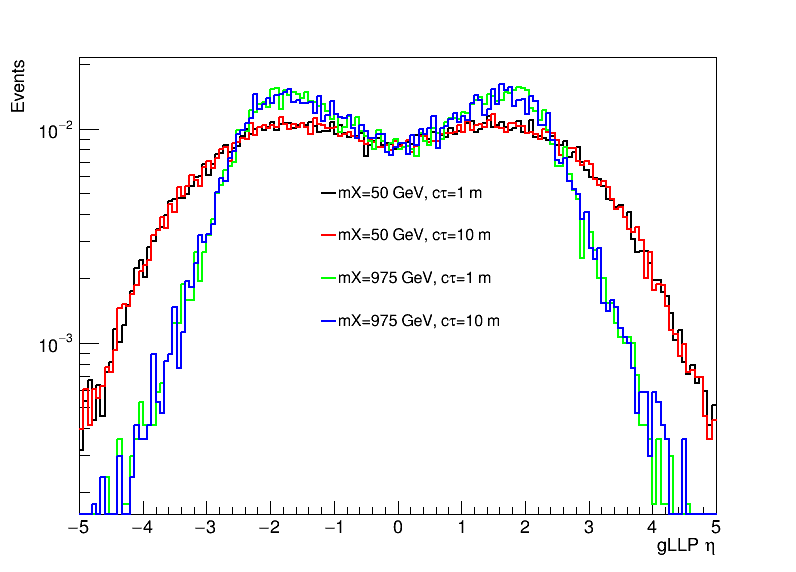

In [24]:
cEta = rt.TCanvas('cEta','cEta', 800, 600)
# h={}
h['gLLP_eta'] = create_TH1D(T['gLLP_eta'][:,0], axis_title=['gLLP_eta', 'Events'], name='gLLP_eta', binning=[150,-5,5])
h['gLLP_eta_low_ctau10'] = create_TH1D(T_low_ctau10['gLLP_eta'][:,0], axis_title=['gLLP_eta', 'Events'], name='gLLP_eta_low_ctau10', binning=[150,-5,5])
h['gLLP_eta_high_ctau1'] = create_TH1D(T_high_ctau1['gLLP_eta'][:,0], axis_title=['gLLP_eta', 'Events'], name='gLLP_eta_high_ctau1', binning=[150,-5,5])
h['gLLP_eta_high_ctau10'] = create_TH1D(T_high_ctau10['gLLP_eta'][:,0], axis_title=['gLLP_eta', 'Events'], name='gLLP_eta_high_ctau10', binning=[150,-5,5])


cEta.SetLogy()

h['gLLP_eta'].Scale(1.0/h['gLLP_eta'].Integral())
h['gLLP_eta_low_ctau10'].Scale(1.0/h['gLLP_eta_low_ctau10'].Integral())
h['gLLP_eta_high_ctau1'].Scale(1.0/h['gLLP_eta_high_ctau1'].Integral())
h['gLLP_eta_high_ctau10'].Scale(1.0/h['gLLP_eta_high_ctau10'].Integral())


h['gLLP_eta'].GetXaxis().SetRangeUser(-5,5)

h['gLLP_eta'].SetLineWidth(2)
h['gLLP_eta'].SetLineColor(1)

h['gLLP_eta_low_ctau10'].SetLineWidth(2)
h['gLLP_eta_low_ctau10'].SetLineColor(2)

h['gLLP_eta_high_ctau1'].SetLineWidth(2)
h['gLLP_eta_high_ctau1'].SetLineColor(3)

h['gLLP_eta_high_ctau10'].SetLineWidth(2)
h['gLLP_eta_high_ctau10'].SetLineColor(4)

h['gLLP_eta'].SetStats(0)
h['gLLP_eta'].SetTitle("")
h['gLLP_eta'].SetXTitle("gLLP #eta")

h['gLLP_eta'].Draw('histo')
h['gLLP_eta_low_ctau10'].Draw('histo+same')
h['gLLP_eta_high_ctau1'].Draw('histo+same')
h['gLLP_eta_high_ctau10'].Draw('histo+same')


legend = rt.TLegend(0.40,0.40,0.5,0.7);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['gLLP_eta'], "mX=50 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['gLLP_eta_low_ctau10'], "mX=50 GeV, c#tau=10 m" , "L");
legend.AddEntry( h['gLLP_eta_high_ctau1'], "mX=975 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['gLLP_eta_high_ctau10'], "mX=975 GeV, c#tau=10 m" , "L");
legend.Draw();

cEta.Draw()

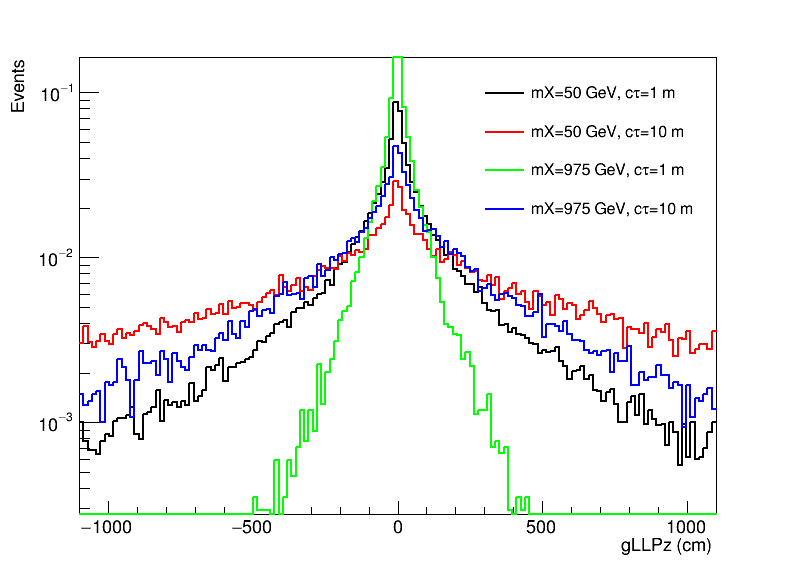

In [25]:
cZ = rt.TCanvas('cZ','cZ', 800, 600)
# h={}
h['gLLP_z'] = create_TH1D(T['gLLP_decay_vertex_z'][:,0], axis_title=['gLLP_z', 'Events'], name='gLLP_z', binning=[150,-1100,1100])
h['gLLP_z_low_ctau10'] = create_TH1D(T_low_ctau10['gLLP_decay_vertex_z'][:,0], axis_title=['gLLP_z', 'Events'], name='gLLP_z_low_ctau10', binning=[150,-1100,1100])
h['gLLP_z_high_ctau1'] = create_TH1D(T_high_ctau1['gLLP_decay_vertex_z'][:,0], axis_title=['gLLP_z', 'Events'], name='gLLP_z_high_ctau1', binning=[150,-1100,1100])
h['gLLP_z_high_ctau10'] = create_TH1D(T_high_ctau10['gLLP_decay_vertex_z'][:,0], axis_title=['gLLP_z', 'Events'], name='gLLP_z_high_ctau10', binning=[150,-1100,1100])


cZ.SetLogy()

h['gLLP_z'].Scale(1.0/h['gLLP_z'].Integral())
h['gLLP_z_low_ctau10'].Scale(1.0/h['gLLP_z_low_ctau10'].Integral())
h['gLLP_z_high_ctau1'].Scale(1.0/h['gLLP_z_high_ctau1'].Integral())
h['gLLP_z_high_ctau10'].Scale(1.0/h['gLLP_z_high_ctau10'].Integral())


h['gLLP_z'].GetXaxis().SetRangeUser(-1100,1100)

h['gLLP_z'].SetLineWidth(2)
h['gLLP_z'].SetLineColor(1)

h['gLLP_z_low_ctau10'].SetLineWidth(2)
h['gLLP_z_low_ctau10'].SetLineColor(2)

h['gLLP_z_high_ctau1'].SetLineWidth(2)
h['gLLP_z_high_ctau1'].SetLineColor(3)

h['gLLP_z_high_ctau10'].SetLineWidth(2)
h['gLLP_z_high_ctau10'].SetLineColor(4)

h['gLLP_z'].SetStats(0)
h['gLLP_z'].SetTitle("")
h['gLLP_z'].SetXTitle("gLLPz (cm)")

h['gLLP_z'].Draw('histo')
h['gLLP_z_low_ctau10'].Draw('histo+same')
h['gLLP_z_high_ctau1'].Draw('histo+same')
h['gLLP_z_high_ctau10'].Draw('histo+same')


legend = rt.TLegend(0.60,0.60,0.87,0.87);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['gLLP_z'], "mX=50 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['gLLP_z_low_ctau10'], "mX=50 GeV, c#tau=10 m" , "L");
legend.AddEntry( h['gLLP_z_high_ctau1'], "mX=975 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['gLLP_z_high_ctau10'], "mX=975 GeV, c#tau=10 m" , "L");
legend.Draw();

cZ.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cDecay


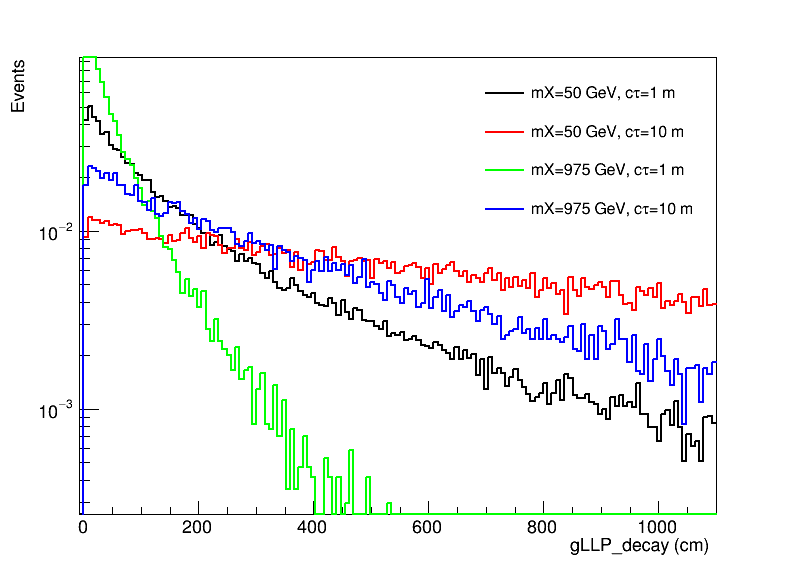

In [30]:
cDecay = rt.TCanvas('cDecay','cDecay', 800, 600)
h={}
h['gLLP_decay'] = create_TH1D(gLLP_decay['ggH'], axis_title=['gLLP_decay_dist', 'Events'], name='gLLP_decay', binning=[150,0,1100])
h['gLLP_decay_low_ctau10'] = create_TH1D(gLLP_decay['m50ct10m'], axis_title=['gLLP_decay_dist', 'Events'], name='gLLP_decay_low_ctau10', binning=[150,0,1100])
h['gLLP_decay_high_ctau1'] = create_TH1D(gLLP_decay['m975ct1m'], axis_title=['gLLP_decay_dist', 'Events'], name='gLLP_decay_high_ctau1', binning=[150,0,1100])
h['gLLP_decay_high_ctau10'] = create_TH1D(gLLP_decay['m975ct10m'], axis_title=['gLLP_decay_dist', 'Events'], name='gLLP_decay_high_ctau10', binning=[150,0,1100])


cDecay.SetLogy()

h['gLLP_decay'].Scale(1.0/h['gLLP_decay'].Integral())
h['gLLP_decay_low_ctau10'].Scale(1.0/h['gLLP_decay_low_ctau10'].Integral())
h['gLLP_decay_high_ctau1'].Scale(1.0/h['gLLP_decay_high_ctau1'].Integral())
h['gLLP_decay_high_ctau10'].Scale(1.0/h['gLLP_decay_high_ctau10'].Integral())


h['gLLP_decay'].GetXaxis().SetRangeUser(-1,1100)

h['gLLP_decay'].SetLineWidth(2)
h['gLLP_decay'].SetLineColor(1)

h['gLLP_decay_low_ctau10'].SetLineWidth(2)
h['gLLP_decay_low_ctau10'].SetLineColor(2)

h['gLLP_decay_high_ctau1'].SetLineWidth(2)
h['gLLP_decay_high_ctau1'].SetLineColor(3)

h['gLLP_decay_high_ctau10'].SetLineWidth(2)
h['gLLP_decay_high_ctau10'].SetLineColor(4)

h['gLLP_decay'].SetStats(0)
h['gLLP_decay'].SetTitle("")
h['gLLP_decay'].SetXTitle("gLLP_decay (cm)")

h['gLLP_decay'].Draw('histo')
h['gLLP_decay_low_ctau10'].Draw('histo+same')
h['gLLP_decay_high_ctau1'].Draw('histo+same')
h['gLLP_decay_high_ctau10'].Draw('histo+same')


legend = rt.TLegend(0.60,0.60,0.87,0.87);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['gLLP_decay'], "mX=50 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['gLLP_decay_low_ctau10'], "mX=50 GeV, c#tau=10 m" , "L");
legend.AddEntry( h['gLLP_decay_high_ctau1'], "mX=975 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['gLLP_decay_high_ctau10'], "mX=975 GeV, c#tau=10 m" , "L");
legend.Draw();

cDecay.Draw()

In [31]:
cscT_average = {}
cscT_median = {}

for species, arbor in data_trees.items():
#     print(treeName, model)
    cscT_average[species] = []
    cscT_median[species] = []
    for eventT in arbor['cscT']:
        time_avg = np.mean(eventT)
        time_med = np.median(eventT)
        cscT_average[species].append(time_avg)
        cscT_median[species].append(time_med)

/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cT


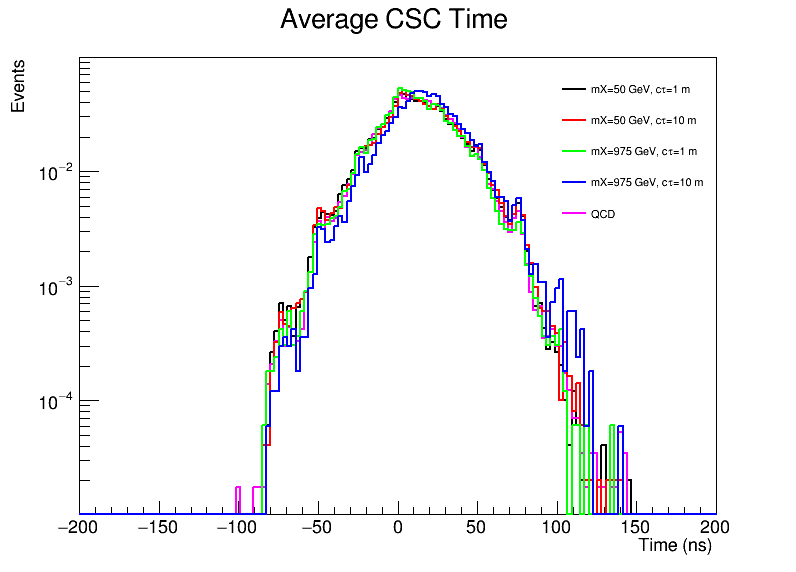

In [33]:
cT = rt.TCanvas('cT','cT', 800, 600)
h={}
h['csc_t_ggH'] = create_TH1D(cscT_average['ggH'], axis_title=['Time', 'Events'], name='csc_t_ggH', binning=[150,-200,200])
h['csc_t_qcd'] = create_TH1D(cscT_average['qcd'], axis_title=['Time', 'Events'], name='csc_t_qcd', binning=[150,-200,200])
h['csc_t_low_ctau10'] = create_TH1D(cscT_average['m50ct10m'], axis_title=['Time', 'Events'], name='csc_t_low_ctau10', binning=[150,-200,200])
h['csc_t_high_ctau1'] = create_TH1D(cscT_average['m975ct1m'], axis_title=['Time', 'Events'], name='csc_t_high_ctau1', binning=[150,-200,200])
h['csc_t_high_ctau10'] = create_TH1D(cscT_average['m975ct10m'], axis_title=['Time', 'Events'], name='csc_t_high_ctau10', binning=[150,-200,200])


cT.SetLogy()

h['csc_t_ggH'].Scale(1.0/h['csc_t_ggH'].Integral())
h['csc_t_qcd'].Scale(1.0/h['csc_t_qcd'].Integral())
h['csc_t_low_ctau10'].Scale(1.0/h['csc_t_low_ctau10'].Integral())
h['csc_t_high_ctau1'].Scale(1.0/h['csc_t_high_ctau1'].Integral())
h['csc_t_high_ctau10'].Scale(1.0/h['csc_t_high_ctau10'].Integral())


h['csc_t_ggH'].GetXaxis().SetRangeUser(-200,200)

h['csc_t_ggH'].SetLineWidth(2)
h['csc_t_ggH'].SetLineColor(1)

h['csc_t_low_ctau10'].SetLineWidth(2)
h['csc_t_low_ctau10'].SetLineColor(2)
# h['csc_t_low_ctau10'].SetLineStyle(2)

h['csc_t_high_ctau1'].SetLineWidth(2)
h['csc_t_high_ctau1'].SetLineColor(3)
# h['csc_t_high_ctau1'].SetLineStyle(1)

h['csc_t_high_ctau10'].SetLineWidth(2)
h['csc_t_high_ctau10'].SetLineColor(4)
# h['csc_t_high_ctau10'].SetLineStyle(2)

h['csc_t_qcd'].SetLineWidth(2)
h['csc_t_qcd'].SetLineColor(6)

h['csc_t_ggH'].SetStats(0)
h['csc_t_ggH'].SetTitle("Average CSC Time")
h['csc_t_ggH'].SetXTitle("Time (ns)")

h['csc_t_ggH'].Draw('histo')
h['csc_t_qcd'].Draw('histo+same')
h['csc_t_low_ctau10'].Draw('histo+same')
h['csc_t_high_ctau1'].Draw('histo+same')
h['csc_t_high_ctau10'].Draw('histo+same')


legend = rt.TLegend(0.70,0.60,0.87,0.87);
legend.SetTextSize(0.02);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['csc_t_ggH'], "mX=50 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['csc_t_low_ctau10'], "mX=50 GeV, c#tau=10 m" , "L");
legend.AddEntry( h['csc_t_high_ctau1'], "mX=975 GeV, c#tau=1 m" , "L");
legend.AddEntry( h['csc_t_high_ctau10'], "mX=975 GeV, c#tau=10 m" , "L");
legend.AddEntry( h['csc_t_qcd'], "QCD" , "L");
legend.Draw();

cT.Draw()

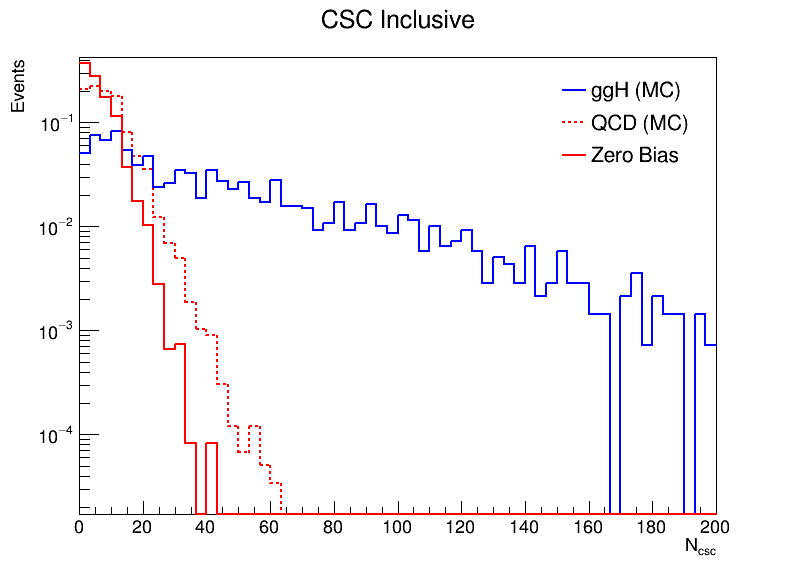

In [34]:
c = rt.TCanvas('c','c', 800, 600)
h['nCsc_ggH'] = create_TH1D(nCsc['ggH'], axis_title=['nCsc_ggH', 'Events'], name='nCsc_ggH', binning=[150,0,500])
h['nCsc_ggH'].SetLineColor(4)

h['nCsc_qcd'] = create_TH1D(nCsc['qcd'], axis_title=['nCsc_qcd', 'Events'], name='nCsc_qcd', binning=[150,0,500])
h['nCsc_qcd'].SetLineColor(2)
h['nCsc_qcd'].SetLineStyle(2)


h['nCsc_zeroBias'] = create_TH1D(nCsc['zeroBias'], axis_title=['nCsc_zeroBias', 'Events'], name='nCsc_zeroBias', binning=[150,0,500])
h['nCsc_zeroBias'].SetLineColor(2)
h['nCsc_zeroBias'].SetLineStyle(1)

c.SetLogy()

h['nCsc_ggH'].Scale(1.0/h['nCsc_ggH'].Integral())
h['nCsc_qcd'].Scale(1.0/h['nCsc_qcd'].Integral())
h['nCsc_zeroBias'].Scale(1.0/h['nCsc_zeroBias'].Integral())


h['nCsc_ggH'].SetLineWidth(2)
h['nCsc_qcd'].SetLineWidth(2)
h['nCsc_zeroBias'].SetLineWidth(2)

h['nCsc_ggH'].GetXaxis().SetRangeUser(0,200)
h['nCsc_qcd'].GetXaxis().SetRangeUser(0,200)
h['nCsc_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['nCsc_qcd'].SetStats(0)
h['nCsc_qcd'].SetTitle("CSC Inclusive")
h['nCsc_qcd'].SetXTitle("N_{csc}")


h['nCsc_qcd'].Draw('histo')
h['nCsc_ggH'].Draw('histo+same')
h['nCsc_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nCsc_ggH'], "ggH (MC)" , "L");
legend.AddEntry( h['nCsc_qcd'], "QCD (MC)" , "L");
legend.AddEntry( h['nCsc_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: nCsc_ggH (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nCsc_qcd (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nCsc_zeroBias (Potential memory leak).


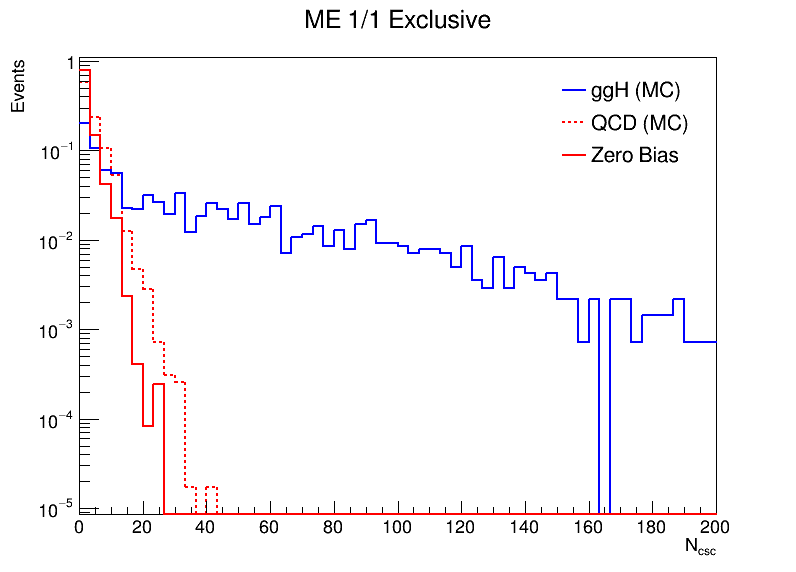

In [35]:
c2 = rt.TCanvas('c2','c2', 800, 600)

h['nCsc_ggH'] = create_TH1D(nCsc_removal['ggH']['ME_11'], axis_title=['nCsc_ggH', 'Events'], name='nCsc_ggH', binning=[150,0,500])
h['nCsc_ggH'].SetLineColor(4)

h['nCsc_qcd'] = create_TH1D(nCsc_removal['qcd']['ME_11'], axis_title=['nCsc_qcd', 'Events'], name='nCsc_qcd', binning=[150,0,500])
h['nCsc_qcd'].SetLineColor(2)
h['nCsc_qcd'].SetLineStyle(2)


h['nCsc_zeroBias'] = create_TH1D(nCsc_removal['zeroBias']['ME_11'], axis_title=['nCsc_zeroBias', 'Events'], name='nCsc_zeroBias', binning=[150,0,500])
h['nCsc_zeroBias'].SetLineColor(2)
h['nCsc_zeroBias'].SetLineStyle(1)

c2.SetLogy()

h['nCsc_ggH'].Scale(1.0/h['nCsc_ggH'].Integral())
h['nCsc_qcd'].Scale(1.0/h['nCsc_qcd'].Integral())
h['nCsc_zeroBias'].Scale(1.0/h['nCsc_zeroBias'].Integral())


h['nCsc_ggH'].SetLineWidth(2)
h['nCsc_qcd'].SetLineWidth(2)
h['nCsc_zeroBias'].SetLineWidth(2)

h['nCsc_ggH'].GetXaxis().SetRangeUser(0,200)
h['nCsc_qcd'].GetXaxis().SetRangeUser(0,200)
h['nCsc_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['nCsc_qcd'].SetStats(0)
h['nCsc_qcd'].SetTitle("ME 1/1 Exclusive")
h['nCsc_qcd'].SetXTitle("N_{csc}")


h['nCsc_qcd'].Draw('histo')
h['nCsc_ggH'].Draw('histo+same')
h['nCsc_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nCsc_ggH'], "ggH (MC)" , "L");
legend.AddEntry( h['nCsc_qcd'], "QCD (MC)" , "L");
legend.AddEntry( h['nCsc_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c2.Draw()

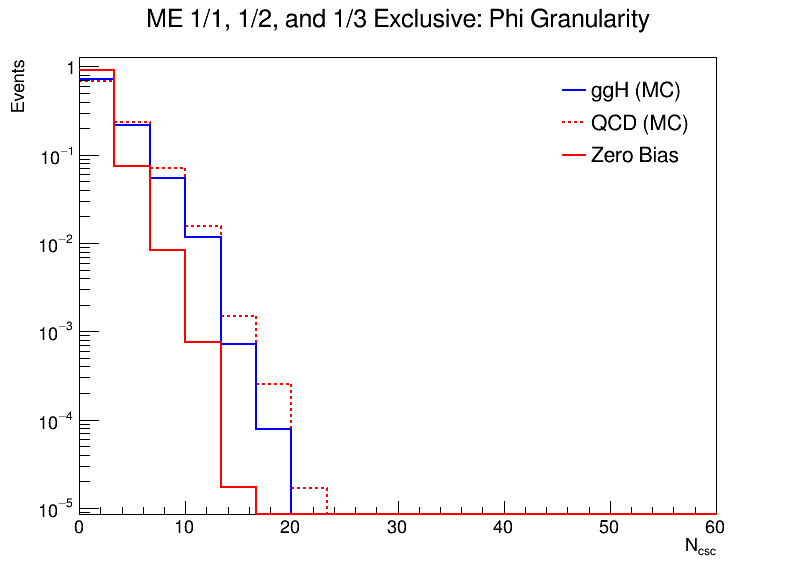

In [36]:
cPg = rt.TCanvas('cPg','cPg', 800, 600)
h={}
h['nCsc_ggH_pg'] = create_TH1D(pg_ncsc_noME1123['ggH'], axis_title=['nCsc_ggH', 'Events'], name='nCsc_ggH_pg', binning=[150,0,500])
h['nCsc_ggH_pg'].SetLineColor(4)

h['nCsc_qcd_pg'] = create_TH1D(pg_ncsc_noME1123['qcd'], axis_title=['nCsc_qcd', 'Events'], name='nCsc_qcd_pg', binning=[150,0,500])
h['nCsc_qcd_pg'].SetLineColor(2)
h['nCsc_qcd_pg'].SetLineStyle(2)


h['nCsc_zeroBias_pg'] = create_TH1D(pg_ncsc_noME1123['zeroBias'], axis_title=['nCsc_zeroBias', 'Events'], name='nCsc_zeroBias_pg', binning=[150,0,500])
h['nCsc_zeroBias_pg'].SetLineColor(2)
h['nCsc_zeroBias_pg'].SetLineStyle(1)

cPg.SetLogy()

h['nCsc_ggH_pg'].Scale(1.0/h['nCsc_ggH_pg'].Integral())
h['nCsc_qcd_pg'].Scale(1.0/h['nCsc_qcd_pg'].Integral())
h['nCsc_zeroBias_pg'].Scale(1.0/h['nCsc_zeroBias_pg'].Integral())


h['nCsc_ggH_pg'].SetLineWidth(2)
h['nCsc_qcd_pg'].SetLineWidth(2)
h['nCsc_zeroBias_pg'].SetLineWidth(2)

h['nCsc_ggH_pg'].GetXaxis().SetRangeUser(0,60)
h['nCsc_qcd_pg'].GetXaxis().SetRangeUser(0,60)
h['nCsc_zeroBias_pg'].GetXaxis().SetRangeUser(0,60)


h['nCsc_qcd_pg'].SetStats(0)
h['nCsc_qcd_pg'].SetTitle("ME 1/1, 1/2, and 1/3 Exclusive: Phi Granularity")
h['nCsc_qcd_pg'].SetXTitle("N_{csc}")


h['nCsc_qcd_pg'].Draw('histo')
h['nCsc_ggH_pg'].Draw('histo+same')
h['nCsc_zeroBias_pg'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nCsc_ggH_pg'], "ggH (MC)" , "L");
legend.AddEntry( h['nCsc_qcd_pg'], "QCD (MC)" , "L");
legend.AddEntry( h['nCsc_zeroBias_pg'], "Zero Bias" , "L");

legend.Draw();

cPg.Draw()

In [37]:
# Clustering Implementation

# Action Plan
# Take the delta phi of the most frequent cluster per station
# Of the most frequent station, append delta phi
# Take out multiplicity for timing study


# Implement SNIC

In [91]:
n_c_total = {}
n_c_hits_12 = {}
n_c_hits_13 = {}

delta_t_max_freq = {}
delta_t_max = {}
# delta_t_average = {}

def sel_clustering(station, model): # Add (, model) for gen level info
        eta_data_sel = data_sel[station][0]
        t_data_sel = data_sel[station][1]
        z_data_sel = data_sel[station][2]
        if station == 2 or station == -2:
            x_data_sel = data_sel[station][3]
            y_data_sel = data_sel[station][4]
        else:
            x_data_sel = np.zeros(len(eta_data_sel))
            y_data_sel = np.zeros(len(eta_data_sel))
            
        test_dataset = np.vstack((eta_data_sel, t_data_sel)).T
        
        # Centroid_constituents is a list of all of the hits corresponding to each centroid
        # etaPhi_labels is a list of the centroids corresponding to each hit
        centroids, centroid_constituents = kmeans(test_dataset, 25)
        etaPhi_labels = getLabels(test_dataset, centroids, 2)
        
#         print(centroid_constituents)
#         print(etaPhi_labels)
        
        # Determines nCsc for all clusters
        total_hits = 0
        for cc in centroid_constituents:
            if cc > 3:
                total_hits += cc
        
        n_c_total[data_type][station].append(total_hits)
        
        # Separates and counts hits in ME 1/2 and ME 1/3
        z_final = np.array([])
        t_final = np.array([])
        r_final_123_sel = np.array([])
        cluster_freq = np.array([])
        for cluster in np.unique(etaPhi_labels):
            if np.count_nonzero(etaPhi_labels == cluster) > 3:
                if cluster != 0:
                    z_final = np.append(z_final, z_data_sel[etaPhi_labels == cluster])
                    x_final_123_sel = x_data_sel[etaPhi_labels == cluster]
                    y_final_123_sel = y_data_sel[etaPhi_labels == cluster]
                    r_final_123_sel = np.append(r_final_123_sel, np.sqrt(x_final_123_sel**2+y_final_123_sel**2))
                    cluster_freq = np.append(cluster_freq, centroid_constituents[cluster])
                    t_final = np.append(t_final, t_data_sel[etaPhi_labels == cluster])
                

        if t_final.shape[0] == 0:
#             t_final = np.append(t_final, np.nan)
            delta_t_max[data_type][station].append(np.nan)
            delta_t_max_freq[data_type][station].append(np.nan)
            
        else:
            max_cluster_freq = np.amax(cluster_freq)
            delta_t_max_freq[data_type][station].append(max_cluster_freq)
            t_cluster = t_data_sel[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][0])]
            if len(t_cluster) != 0:
                if etaPhi_labels[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][0])][0] != 0:
#                     max_t = np.max(t_cluster)
#                     min_t = np.min(t_cluster)
                    delta_t = np.mean(t_cluster)
                    delta_t_max[data_type][station].append(delta_t)
                    
                else:
                    t_cluster_prime = t_data_sel[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][1])]
#                     max_t = np.max(t_cluster_prime)
#                     min_t = np.min(t_cluster_prime)
                    delta_t = np.mean(t_cluster)
                    delta_t_max[data_type][station].append(delta_t)
#                     if delta_t > 1:
# #                         print(max_t)
# #                         print(min_t)
#                         print(etaPhi_labels[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][0])])
#                         print(etaPhi_labels[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][1])])
#                         print(max_cluster_freq)
#                         print(etaPhi_labels)
            else:
                t_cluster_prime = t_data_sel[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][1])]
                max_t = np.max(t_cluster_prime)
                min_t = np.min(t_cluster_prime)
                delta_t = np.mean(t_cluster)
                delta_t_max[data_type][station].append(delta_t)

        
        if r_final_123_sel.shape[0] == 0:
            n_c_hits_12[data_type][station].append(0.0)
            n_c_hits_13[data_type][station].append(0.0)
        else:
            sel_counter_12 = 0
            sel_counter_13 = 0
            for hit_r in r_final_123_sel:
                if hit_r < 465 and hit_r > 275:
                    sel_counter_12 += 1
                if hit_r < 695.5 and hit_r > 505.5:
                    sel_counter_13 += 1
            n_c_hits_12[data_type][station].append(sel_counter_12)
            n_c_hits_13[data_type][station].append(sel_counter_13)
#         print(t_data_sel)
#         if t_final.shape[0] == 0:
#             delta_t_max[data_type][station].append(0.0)
#             delta_t_average[data_type][station].append(0.0)
#         else:
#             if np.absolute(np.amax(t_final)) > np.absolute(np.amin(t_final)):
#                 delta_t_max[data_type][station].append(np.amax(t_final))
#             else:
#                 delta_t_max[data_type][station].append(np.amin(t_final))
#             delta_t_average[data_type][station].append(np.sum(t_final)/len(t_final))

In [92]:
print('Start: '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
for data_type in data_trees.keys():
    n_c_total[data_type] = {}
    n_c_total[data_type]['total'] = []
    
    delta_t_max[data_type] = {}
    delta_t_max[data_type]['total'] = []
    
    delta_t_max_freq[data_type] = {}

#     delta_t_average[data_type] = {}
#     delta_t_average[data_type]['total'] = []
    
    n_c_hits_12[data_type] = {}
    n_c_hits_13[data_type] = {}

    csc_sections = [1,2,3,4,5, -1, -2, -3, -4, -5]
    for section in csc_sections:
        n_c_total[data_type][section] = []
        n_c_hits_12[data_type][section] = []
        n_c_hits_13[data_type][section] = []
        
        delta_t_max[data_type][section] = []
        delta_t_max_freq[data_type][section] = []
        
#         delta_t_average[data_type][section] = []

            
    for sel_event in range(csc_eta[data_type].shape[0]):

        data_sel = {}

        # 1/1 if 568 < zPos < 632:
        hits_pos1_sel = np.logical_and(csc_z[data_type][sel_event]<632, csc_z[data_type][sel_event]>568)
        hits_neg1_sel = np.logical_and(csc_z[data_type][sel_event]>-632, csc_z[data_type][sel_event]<-568)
        data_sel[1] = (csc_eta[data_type][sel_event][hits_pos1_sel], csc_t[data_type][sel_event][hits_pos1_sel], csc_z[data_type][sel_event][hits_pos1_sel])
        data_sel[-1] = (csc_eta[data_type][sel_event][hits_neg1_sel], csc_t[data_type][sel_event][hits_neg1_sel], csc_z[data_type][sel_event][hits_neg1_sel])


        # 1/2 and 1/3 elif 663 < zPos < 724:
        hits_pos2_sel = np.logical_and(csc_z[data_type][sel_event]<724, csc_z[data_type][sel_event]>663)
        hits_neg2_sel = np.logical_and(csc_z[data_type][sel_event]>-724, csc_z[data_type][sel_event]<-663)
        data_sel[2] = (csc_eta[data_type][sel_event][hits_pos2_sel], csc_t[data_type][sel_event][hits_pos2_sel], csc_z[data_type][sel_event][hits_pos2_sel], csc_x[data_type][sel_event][hits_pos2_sel], csc_y[data_type][sel_event][hits_pos2_sel])
        data_sel[-2] = (csc_eta[data_type][sel_event][hits_neg2_sel], csc_t[data_type][sel_event][hits_neg2_sel], csc_z[data_type][sel_event][hits_neg2_sel], csc_x[data_type][sel_event][hits_neg2_sel], csc_y[data_type][sel_event][hits_neg2_sel])


        # 2/1 and 2/2 elif 791 < zPos < 849.5:
        hits_pos3_sel = np.logical_and(csc_z[data_type][sel_event]<849.5, csc_z[data_type][sel_event]>791)
        hits_neg3_sel = np.logical_and(csc_z[data_type][sel_event]>-849.5, csc_z[data_type][sel_event]<-791)
        data_sel[3] = (csc_eta[data_type][sel_event][hits_pos3_sel], csc_t[data_type][sel_event][hits_pos3_sel], csc_z[data_type][sel_event][hits_pos3_sel])
        data_sel[-3] = (csc_eta[data_type][sel_event][hits_neg3_sel], csc_t[data_type][sel_event][hits_neg3_sel], csc_z[data_type][sel_event][hits_neg3_sel])


        # 3/1 and 3/2 elif 911.5 < zPos < 970:
        hits_pos4_sel = np.logical_and(csc_z[data_type][sel_event]<970, csc_z[data_type][sel_event]>911.5)
        hits_neg4_sel = np.logical_and(csc_z[data_type][sel_event]>-970, csc_z[data_type][sel_event]<-911.5)
        data_sel[4] = (csc_eta[data_type][sel_event][hits_pos4_sel], csc_t[data_type][sel_event][hits_pos4_sel], csc_z[data_type][sel_event][hits_pos4_sel])
        data_sel[-4] = (csc_eta[data_type][sel_event][hits_neg4_sel], csc_t[data_type][sel_event][hits_neg4_sel], csc_z[data_type][sel_event][hits_neg4_sel])


        # 4/1 and 4/2 elif 1002 < zPos < 1060.5:
        hits_pos5_sel = np.logical_and(csc_z[data_type][sel_event]<1060.5, csc_z[data_type][sel_event]>1002.5)
        hits_neg5_sel = np.logical_and(csc_z[data_type][sel_event]>-1060.5, csc_z[data_type][sel_event]<-1002.5)
        data_sel[5] = (csc_eta[data_type][sel_event][hits_pos5_sel], csc_t[data_type][sel_event][hits_pos5_sel], csc_z[data_type][sel_event][hits_pos5_sel])
        data_sel[-5] = (csc_eta[data_type][sel_event][hits_neg5_sel], csc_t[data_type][sel_event][hits_neg5_sel], csc_z[data_type][sel_event][hits_neg5_sel])

        sel_clustering(1, data_type)
        sel_clustering(-1, data_type)
        sel_clustering(2, data_type)
        sel_clustering(-2, data_type)
        sel_clustering(3, data_type)
        sel_clustering(-3, data_type)
        sel_clustering(4, data_type)
        sel_clustering(-4, data_type)
        sel_clustering(5, data_type)
        sel_clustering(-5, data_type)

        ncsc_temp = 0.0
        t_max_temp = np.array([])
        t_freq_temp = []
        
        for x in csc_sections:
            ncsc_temp += n_c_total[data_type][x][-1]
            t_freq_temp.append(delta_t_max_freq[data_type][x][-1])
            t_max_temp = np.append(t_max_temp, delta_t_max[data_type][x][-1])


        n_c_total[data_type]['total'].append(ncsc_temp)
        
        if len(t_freq_temp) == len(csc_sections):
            t_freq_temp = np.nan_to_num(t_freq_temp).astype(int)
            max_freq = np.amax(t_freq_temp)
            max_freq_index = np.where(t_freq_temp == max_freq)
#             print(t_max_temp[max_freq_index][0])
#             if np.absolute(np.amax(t_max_temp[max_freq_index])) > np.absolute(np.amin(t_max_temp[max_freq_index])):
#                 max_delT = np.amax(t_max_temp[max_freq_index])
#             else:
#                 max_delT = np.amin(t_max_temp[max_freq_index])
                
            delta_t_max[data_type]['total'].append(t_max_temp[max_freq_index][0])
            
#             if len((t_max_temp[max_freq_index])) != len(csc_sections):
#                 if np.absolute(np.amax(t_max_temp[max_freq_index])) > np.absolute(np.amin(t_max_temp[max_freq_index])):
#                     max_delPhi = np.amax(t_max_temp[max_freq_index])
#                 else:
#                     max_delPhi = np.amin(t_max_temp[max_freq_index])
#                 delta_t_max[data_type]['total'].append(max_delPhi)
#             else:
#                 delta_t_max[data_type]['total'].append(np.nan)
        else:
            print("Function error")
                
        if (sel_event % 1000) == 0:
            print(str(sel_event) + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
            
#         if np.absolute(np.amax(t_avg_temp)) > np.absolute(np.amin(t_avg_temp)):
#             delta_t_max[data_type]['total'].append(np.amax(t_avg_temp))
#         else:
#             delta_t_max[data_type]['total'].append(np.amin(t_avg_temp))
            
#         delta_t_average[data_type]['total'].append(np.sum(t_avg_temp)/len(t_avg_temp))        
#         break
        
    print(data_type + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
#     break

Start: 2019-07-22 13:50:16.058054-07:00
0: 2019-07-22 13:50:16.077060-07:00
1000: 2019-07-22 13:50:28.472230-07:00
ggH: 2019-07-22 13:50:33.532476-07:00
0: 2019-07-22 13:50:33.541496-07:00
1000: 2019-07-22 13:50:43.378855-07:00
2000: 2019-07-22 13:50:53.295101-07:00
3000: 2019-07-22 13:51:07.364387-07:00
4000: 2019-07-22 13:51:22.169115-07:00
5000: 2019-07-22 13:51:33.268413-07:00
6000: 2019-07-22 13:51:44.787034-07:00
7000: 2019-07-22 13:51:58.373254-07:00
8000: 2019-07-22 13:52:08.229128-07:00
9000: 2019-07-22 13:52:23.300548-07:00
10000: 2019-07-22 13:52:33.029902-07:00
11000: 2019-07-22 13:52:42.850895-07:00
12000: 2019-07-22 13:52:53.180832-07:00
13000: 2019-07-22 13:53:06.905207-07:00
14000: 2019-07-22 13:53:16.678540-07:00
15000: 2019-07-22 13:53:26.406640-07:00
16000: 2019-07-22 13:53:36.138001-07:00
17000: 2019-07-22 13:53:45.719953-07:00
18000: 2019-07-22 13:53:58.210050-07:00
19000: 2019-07-22 13:54:09.479411-07:00
20000: 2019-07-22 13:54:19.413076-07:00
21000: 2019-07-22 13

/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


1000: 2019-07-22 14:03:27.189959-07:00
2000: 2019-07-22 14:03:38.914451-07:00
3000: 2019-07-22 14:03:53.517206-07:00
m50ct10m: 2019-07-22 14:04:03.323376-07:00
0: 2019-07-22 14:04:03.340997-07:00
m975ct1m: 2019-07-22 14:04:03.443235-07:00
0: 2019-07-22 14:04:03.453646-07:00
1000: 2019-07-22 14:04:14.185189-07:00
m975ct10m: 2019-07-22 14:04:21.126398-07:00


In [93]:
nCsc_cluster = {}
for data_type in data_trees.keys():
    nCsc_cluster[data_type] = {}
    nCsc_cluster[data_type]['csc_inclusive'] = np.array(n_c_total[data_type]['total'])
    nCsc_cluster[data_type]['csc_noME11'] = np.array(n_c_total[data_type]['total']) - (np.array(n_c_total[data_type][1]) + np.array(n_c_total[data_type][-1]))
    nCsc_cluster[data_type]['csc_noME112'] = np.array(n_c_total[data_type]['total']) - (np.array(n_c_total[data_type][1]) + np.array(n_c_total[data_type][-1]) + np.array(n_c_hits_12[data_type][2]) + np.array(n_c_hits_12[data_type][-2]))
    nCsc_cluster[data_type]['csc_noME1123'] = np.array(n_c_total[data_type]['total']) - (np.array(n_c_total[data_type][1]) + np.array(n_c_total[data_type][-1]) + np.array(n_c_total[data_type][2]) + np.array(n_c_total[data_type][-2]))

In [94]:
# ROC Curve for ggH/QCD/ZeroBias Samples: nCsc 

eff_ncsc = {}
rejection_power = {}
ncsc_var_x = np.array([])

for data_type in data_trees.keys():
    eff_ncsc[data_type] = {}
    
    eff_ncsc[data_type]['cluster'] = {}
    eff_ncsc[data_type]['cluster']['csc_inclusive'] = np.array([])
    eff_ncsc[data_type]['cluster']['csc_noME11'] = np.array([])
    eff_ncsc[data_type]['cluster']['csc_noME112'] = np.array([])
    eff_ncsc[data_type]['cluster']['csc_noME1123'] = np.array([])
    
    eff_ncsc[data_type]['noCluster'] = {}
    eff_ncsc[data_type]['noCluster']['csc_inclusive'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME11'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME112'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME1123'] = np.array([])
    
    for hit_thresh in range(0, 200):
        ncsc_var_x = np.append(ncsc_var_x, hit_thresh)
        # Clustering ROCs
        eff_ncsc[data_type]['cluster']['csc_inclusive'] = np.append(eff_ncsc[data_type]['cluster']['csc_inclusive'], np.count_nonzero(np.array(nCsc_cluster[data_type]['csc_inclusive'])>hit_thresh)/len(nCsc_cluster[data_type]['csc_inclusive']))
        eff_ncsc[data_type]['cluster']['csc_noME11'] = np.append(eff_ncsc[data_type]['cluster']['csc_noME11'], np.count_nonzero(np.array(nCsc_cluster[data_type]['csc_noME11'])>hit_thresh)/len(nCsc_cluster[data_type]['csc_noME11']))
        eff_ncsc[data_type]['cluster']['csc_noME112'] = np.append(eff_ncsc[data_type]['cluster']['csc_noME112'], np.count_nonzero(np.array(nCsc_cluster[data_type]['csc_noME112'])>hit_thresh)/len(nCsc_cluster[data_type]['csc_noME112']))
        eff_ncsc[data_type]['cluster']['csc_noME1123'] = np.append(eff_ncsc[data_type]['cluster']['csc_noME1123'], np.count_nonzero(np.array(nCsc_cluster[data_type]['csc_noME1123'])>hit_thresh)/len(nCsc_cluster[data_type]['csc_noME1123']))

       # No-Clustering ROCs
        eff_ncsc[data_type]['noCluster']['csc_inclusive'] = np.append(eff_ncsc[data_type]['noCluster']['csc_inclusive'], np.count_nonzero(np.array(nCsc[data_type])>hit_thresh)/len(nCsc[data_type]))
        eff_ncsc[data_type]['noCluster']['csc_noME11'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME11'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_11'])>hit_thresh)/len(nCsc_removal[data_type]['ME_11']))
        eff_ncsc[data_type]['noCluster']['csc_noME112'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME112'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_112'])>hit_thresh)/len(nCsc_removal[data_type]['ME_112']))
        eff_ncsc[data_type]['noCluster']['csc_noME1123'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME1123'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_1123'])>hit_thresh)/len(nCsc_removal[data_type]['ME_1123']))
    
    # Rejection power calculation
    rejection_power[data_type] = {}
    rejection_power[data_type]['cluster'] = {}
    rejection_power[data_type]['noCluster'] = {}
    
    # Clustering
    rejection_power[data_type]['cluster']['csc_inclusive'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['cluster']['csc_inclusive']))
    rejection_power[data_type]['cluster']['csc_noME11'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['cluster']['csc_noME11']))
    rejection_power[data_type]['cluster']['csc_noME112'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['cluster']['csc_noME112']))
    rejection_power[data_type]['cluster']['csc_noME1123'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['cluster']['csc_noME1123']))
    # No clustering
    rejection_power[data_type]['noCluster']['csc_inclusive'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_inclusive']))
    rejection_power[data_type]['noCluster']['csc_noME11'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME11']))
    rejection_power[data_type]['noCluster']['csc_noME112'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME112']))
    rejection_power[data_type]['noCluster']['csc_noME1123'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME1123']))


In [95]:
# Calculating Trigger Efficiency

ncsc_thresh = ncsc_var_x[np.where(rejection_power['qcd']['noCluster']['csc_inclusive'] > 10**4)]
signal_eff = eff_ncsc['ggH']['noCluster']['csc_inclusive'][np.where(rejection_power['qcd']['noCluster']['csc_inclusive'] > 10**4)]

print(ncsc_thresh)
print(signal_eff)

[56. 57. 58. 59. 60. 61.]
[0.31902718 0.30972818 0.30543634 0.3018598  0.29470672 0.28826896]


In [96]:
# Calculating Trigger Efficiency * Acceptance with Reco-level info only

sel_reco = np.logical_and(T['nCsc'], np.absolute(T['nCsc'] > ncsc_thresh[0]))
sel_gen = np.logical_and(nCsc['ggH'], nCsc['ggH'] > ncsc_thresh[0])
acceptance = np.count_nonzero(sel_displaced)/len(T['nCsc'])

print('Reco Signal Slice: ' + str(np.count_nonzero(sel_reco)))
print('Gen Signal Slice: ' + str(np.count_nonzero(sel_gen)))
print('Acceptance (Gen selection only): ' + str(acceptance))

print('Signal Fraction (Reco selection only): ' + str(np.count_nonzero(sel_reco)/len(T['nCsc'])))
print('Signal Fraction (Gen selection only): ' + str(acceptance*signal_eff[0]))

locales_gen = np.array(np.where(sel_gen==True))
locales_reco =  np.array(np.where(sel_reco==True))
diff_tEff_acc_methods = np.setdiff1d(locales_gen, locales_reco)

Reco Signal Slice: 711
Gen Signal Slice: 446
Acceptance (Gen selection only): 0.03246396166385168
Signal Fraction (Reco selection only): 0.01396362779370753
Signal Fraction (Gen selection only): 0.010356886196049964


Warning in <TCanvas::Constructor>: Deleting canvas with same name: ctest
Warning in <TROOT::Append>: Replacing existing TH1: ex_events (Potential memory leak).


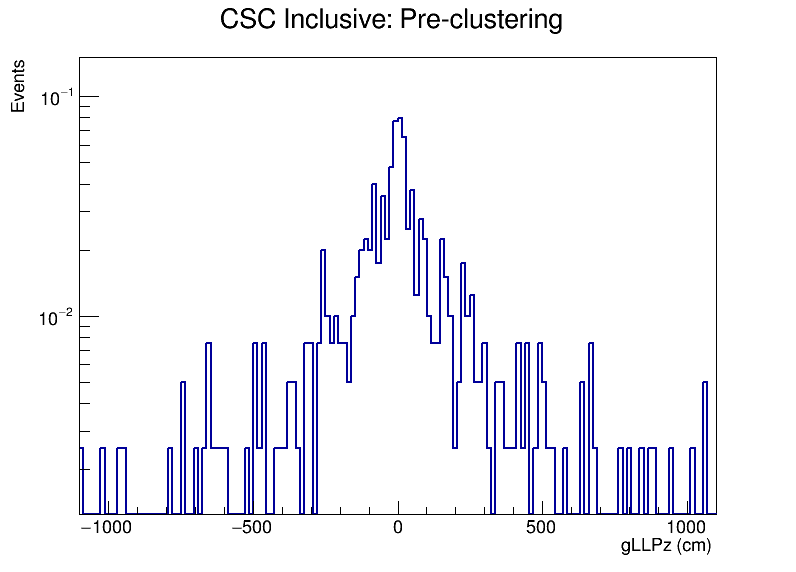

In [97]:
# Events that pass the reco selection but not gen level

ctest = rt.TCanvas('ctest','ctest', 800, 600)
h['ex_events'] = create_TH1D(T['gLLP_decay_vertex_z'][:,0][diff_tEff_acc_methods], axis_title=['nCsc_dis', 'Events'], name='ex_events', binning=[150,-1100,1100])


ctest.SetLogy()

h['ex_events'].Scale(1.0/h['ex_events'].Integral())


h['ex_events'].GetXaxis().SetRangeUser(-1100,1100)

h['ex_events'].SetLineWidth(2)

h['ex_events'].SetStats(0)
h['ex_events'].SetTitle("CSC Inclusive: Pre-clustering")
h['ex_events'].SetXTitle("gLLPz (cm)")
h['ex_events'].Draw('histo')

legend = rt.TLegend(0.60,0.60,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.Draw();

ctest.Draw()

In [98]:
# print(T['eventNum'][diff_tEff_acc_methods])
# print(T['lumiNum'][diff_tEff_acc_methods])

length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Warning in <TLegend::Paint>: Legend to large to be automatically placed. A default position is used


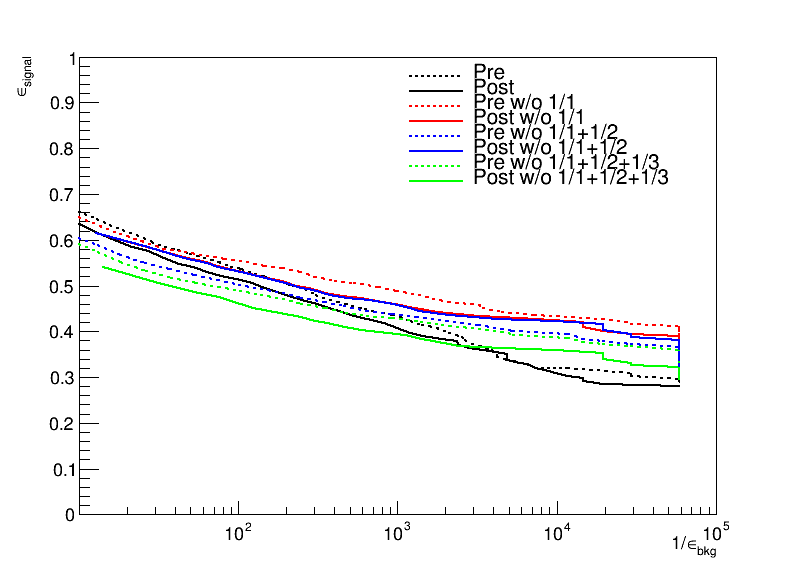

In [99]:
c3 = rt.TCanvas('c3','c3', 800, 600)

h['roc_curve_cluster'] = create_TGraph(rejection_power['qcd']['cluster']['csc_inclusive'], eff_ncsc['ggH']['cluster']['csc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_noCluster'] = create_TGraph(rejection_power['qcd']['noCluster']['csc_inclusive'], eff_ncsc['ggH']['noCluster']['csc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

h['roc_curve_clean_cluster'] = create_TGraph(rejection_power['qcd']['cluster']['csc_noME11'], eff_ncsc['ggH']['cluster']['csc_noME11'], axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_clean_noCluster'] = create_TGraph(rejection_power['qcd']['noCluster']['csc_noME11'], eff_ncsc['ggH']['noCluster']['csc_noME11'], axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])

h['roc_curve_res_cluster'] = create_TGraph(rejection_power['qcd']['cluster']['csc_noME1123'], eff_ncsc['ggH']['cluster']['csc_noME1123'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_res_noCluster'] = create_TGraph(rejection_power['qcd']['noCluster']['csc_noME1123'], eff_ncsc['ggH']['noCluster']['csc_noME1123'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

h['roc_curve_med_cluster'] = create_TGraph(rejection_power['qcd']['cluster']['csc_noME112'], eff_ncsc['ggH']['cluster']['csc_noME112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_med_noCluster'] = create_TGraph(rejection_power['qcd']['noCluster']['csc_noME112'], eff_ncsc['ggH']['noCluster']['csc_noME112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

c3.SetLogx()
# c3.SetLogy()

h['roc_curve_noCluster'].SetTitle('')

h['roc_curve_cluster'].SetLineWidth(2)
h['roc_curve_noCluster'].SetLineWidth(2)

h['roc_curve_clean_cluster'].SetLineWidth(2)
h['roc_curve_clean_noCluster'].SetLineWidth(2)

h['roc_curve_res_cluster'].SetLineWidth(2)
h['roc_curve_res_noCluster'].SetLineWidth(2)

h['roc_curve_med_cluster'].SetLineWidth(2)
h['roc_curve_med_noCluster'].SetLineWidth(2)

h['roc_curve_cluster'].SetLineColor(1)
h['roc_curve_cluster'].SetLineStyle(1)
h['roc_curve_noCluster'].SetLineColor(1)
h['roc_curve_noCluster'].SetLineStyle(2)

h['roc_curve_clean_cluster'].SetLineColor(2)
h['roc_curve_clean_cluster'].SetLineStyle(1)
h['roc_curve_clean_noCluster'].SetLineColor(2)
h['roc_curve_clean_noCluster'].SetLineStyle(2)
                                          
h['roc_curve_res_cluster'].SetLineColor(3)
h['roc_curve_res_cluster'].SetLineStyle(1)
h['roc_curve_res_noCluster'].SetLineColor(3)
h['roc_curve_res_noCluster'].SetLineStyle(2)

h['roc_curve_med_cluster'].SetLineColor(4)
h['roc_curve_med_cluster'].SetLineStyle(1)
h['roc_curve_med_noCluster'].SetLineColor(4)
h['roc_curve_med_noCluster'].SetLineStyle(2)

h['roc_curve_noCluster'].GetXaxis().SetLimits(10, 100000)
h['roc_curve_noCluster'].GetYaxis().SetRangeUser(0,1)



h['roc_curve_noCluster'].Draw()
h['roc_curve_cluster'].Draw('same')
h['roc_curve_clean_cluster'].Draw('same')
h['roc_curve_clean_noCluster'].Draw('same')
h['roc_curve_res_cluster'].Draw('same')
h['roc_curve_med_cluster'].Draw('same')

h['roc_curve_res_noCluster'].Draw('same')
h['roc_curve_med_noCluster'].Draw('same')

legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_curve_noCluster'], "Pre", 'l');
legend.AddEntry( h['roc_curve_cluster'], "Post", 'l');
legend.AddEntry( h['roc_curve_clean_noCluster'], "Pre w/o 1/1", 'l');
legend.AddEntry( h['roc_curve_clean_cluster'], "Post w/o 1/1", 'l');
legend.AddEntry( h['roc_curve_med_noCluster'], "Pre w/o 1/1+1/2", 'l');
legend.AddEntry( h['roc_curve_med_cluster'], "Post w/o 1/1+1/2", 'l');
legend.AddEntry( h['roc_curve_res_noCluster'], "Pre w/o 1/1+1/2+1/3", 'l');
legend.AddEntry( h['roc_curve_res_cluster'], "Post w/o 1/1+1/2+1/3", 'l');


legend.Draw();

c3.Draw()

length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
Warning in <TLegend::Paint>: Legend to large to be automatically placed. A default position is used


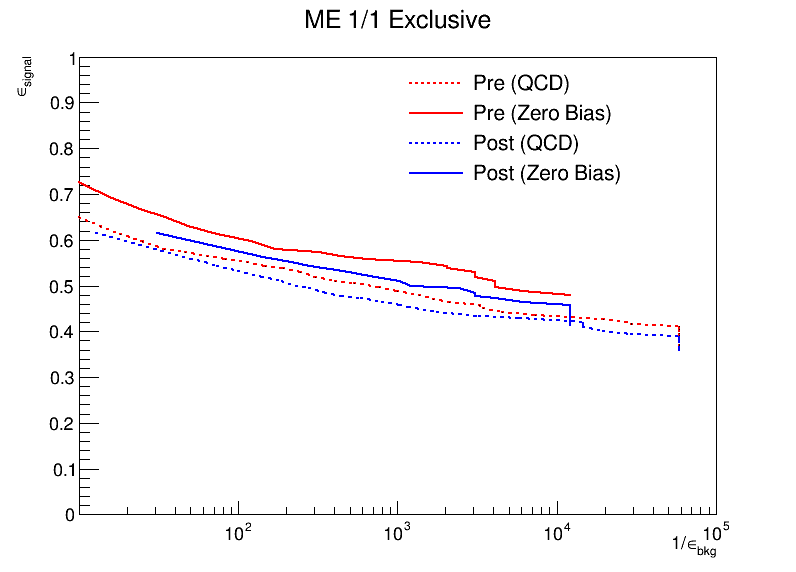

In [100]:
c4 = rt.TCanvas('c4','c4', 800, 600)

h['roc_curve_noCluster_noME11_qcd'] = create_TGraph(rejection_power['qcd']['noCluster']['csc_noME11'], eff_ncsc['ggH']['noCluster']['csc_noME11'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_noCluster_noME11_minBias'] = create_TGraph(rejection_power['zeroBias']['noCluster']['csc_noME11'], eff_ncsc['ggH']['noCluster']['csc_noME11'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

h['roc_curve_cluster_noME11_qcd'] = create_TGraph(rejection_power['qcd']['cluster']['csc_noME11'], eff_ncsc['ggH']['cluster']['csc_noME11'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_cluster_noME11_minBias'] = create_TGraph(rejection_power['zeroBias']['cluster']['csc_noME11'], eff_ncsc['ggH']['cluster']['csc_noME11'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{data}'])


c4.SetLogx()
# c4.SetLogy()

h['roc_curve_noCluster_noME11_qcd'].SetTitle('ME 1/1 Exclusive')

h['roc_curve_noCluster_noME11_qcd'].SetLineWidth(2)
h['roc_curve_noCluster_noME11_minBias'].SetLineWidth(2)

h['roc_curve_cluster_noME11_qcd'].SetLineWidth(2)
h['roc_curve_cluster_noME11_minBias'].SetLineWidth(2)


h['roc_curve_noCluster_noME11_qcd'].SetLineColor(2)
h['roc_curve_noCluster_noME11_qcd'].SetLineStyle(2)
h['roc_curve_noCluster_noME11_minBias'].SetLineColor(2)
h['roc_curve_noCluster_noME11_minBias'].SetLineStyle(1)
                                          
h['roc_curve_cluster_noME11_qcd'].SetLineColor(4)
h['roc_curve_cluster_noME11_qcd'].SetLineStyle(2)
h['roc_curve_cluster_noME11_minBias'].SetLineColor(4)
h['roc_curve_cluster_noME11_minBias'].SetLineStyle(1)

h['roc_curve_noCluster_noME11_qcd'].GetXaxis().SetLimits(10, 100000)
h['roc_curve_noCluster_noME11_qcd'].GetYaxis().SetRangeUser(0,1)



h['roc_curve_noCluster_noME11_qcd'].Draw()
h['roc_curve_noCluster_noME11_minBias'].Draw('same')
h['roc_curve_cluster_noME11_qcd'].Draw('same')
h['roc_curve_cluster_noME11_minBias'].Draw('same')

legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_curve_noCluster_noME11_qcd'], "Pre (QCD)", 'l');
legend.AddEntry( h['roc_curve_noCluster_noME11_minBias'], "Pre (Zero Bias)", 'l');
legend.AddEntry( h['roc_curve_cluster_noME11_qcd'], "Post (QCD)", 'l');
legend.AddEntry( h['roc_curve_cluster_noME11_minBias'], "Post (Zero Bias)", 'l');


legend.Draw();

c4.Draw()

In [101]:
# print(nCsc['ggH'])
# print(time_avg['ggH'])

In [114]:
print(len(cscT_average['zeroBias']))
print(len(delta_t_max['zeroBias']['total']))


1794460
12209


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5
Warning in <TROOT::Append>: Replacing existing TH1: t_max_ggH (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: t_max_qcd (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: t_max_zeroBias (Potential memory leak).


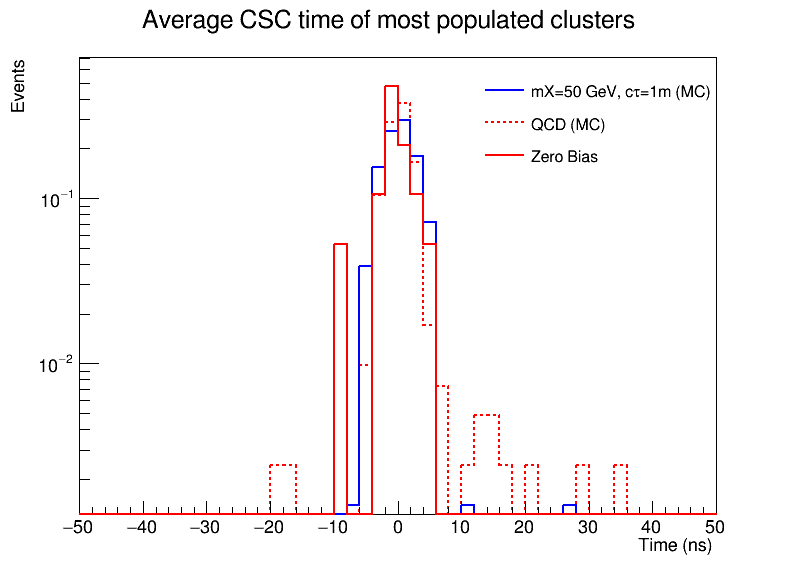

In [110]:
c5 = rt.TCanvas('c5','c5', 800, 600)

h['t_max_ggH'] = create_TH1D(delta_t_max['ggH']['total'], axis_title=['t_max_ggH', 'Events'], name='t_max_ggH', binning=[50,-50,50])
h['t_max_ggH'].SetLineColor(4)

h['t_max_qcd'] = create_TH1D(delta_t_max['qcd']['total'], axis_title=['t_max_qcd', 'Events'], name='t_max_qcd', binning=[50,-50,50])
h['t_max_qcd'].SetLineColor(2)
h['t_max_qcd'].SetLineStyle(2)


h['t_max_zeroBias'] = create_TH1D(delta_t_max['zeroBias']['total'], axis_title=['t_max_zeroBias', 'Events'], name='t_max_zeroBias', binning=[50,-50,50])
h['t_max_zeroBias'].SetLineColor(2)
h['t_max_zeroBias'].SetLineStyle(1)

c5.SetLogy()

h['t_max_ggH'].Scale(1.0/h['t_max_ggH'].Integral())
h['t_max_qcd'].Scale(1.0/h['t_max_qcd'].Integral())
h['t_max_zeroBias'].Scale(1.0/h['t_max_zeroBias'].Integral())


h['t_max_ggH'].SetLineWidth(2)
h['t_max_qcd'].SetLineWidth(2)
h['t_max_zeroBias'].SetLineWidth(2)

# h['t_max_ggH'].GetXaxis().SetRangeUser(-50,50)
h['t_max_qcd'].GetXaxis().SetRangeUser(-50,50)
# h['t_max_zeroBias'].GetXaxis().SetRangeUser(-200,200)


h['t_max_qcd'].SetStats(0)
h['t_max_qcd'].SetTitle("Average CSC time of most populated clusters")
h['t_max_qcd'].SetXTitle("Time (ns)")


h['t_max_qcd'].Draw('histo')
h['t_max_ggH'].Draw('histo+same')
h['t_max_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.60,0.87,0.87,0.7);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['t_max_ggH'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['t_max_qcd'], "QCD (MC)" , "L");
legend.AddEntry( h['t_max_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c5.Draw()